# Anomaly Detection

### Import libaries used
- **Note**: Ensure that the **path** of 'eco-tools' is configured to your computer

In [1]:
import pandas as pd
import numpy as np
import sys
import os
cwd = os.getcwd()
config_path = cwd + '/src/config/mylstmconfig.ini'
import configparser
config = configparser.ConfigParser()
config.read(config_path)
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from src.data_helper import *
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Find point to train on
- **Note**: Esure that only **ONE** point will be used

In [2]:
#search for point 
point = pc.search_by_point('*Cole.B_Electricity_Demand_kBtu')
point

['Cole.B_Electricity_Demand_kBtu']

### Set Data Parameters
- **start**: format `'YYYY-MM-DD'`
- **end**: format `'YYYY-MM-DD'` or `'*'` for up to time now
- **interval**: can be `'1h'` - `'nh'` where **n** is any number of hour intervals, can also use `'m'` for minutes or `'s'` for seconds
- **calculation**: preferred method is `'summary'`

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

## Pull the point's data from PI using eco-tools

**`print_report()`**

-------
Generates report of the percentage of NaN values in the data as well as the number of points that are NaN

**parameters**: 

`df`**-**  pandas `DataFrame` generated by the `get_stream_by_point`

`show_plot`**-** `bool` whether to show the data retrieved from PI

`separate_plots`**-** `bool` if several points where passed and want to see each point in it's own plot

**returns**:
-`None`


Grabbing WebIDs ...
WebID collection complete!
09:49:13: Sending API request... Chunk 1 of 1
09:49:20: Response recieved for 1 tags! (7.6)


Column                        |Percent NaN | Rows NaN/Total Rows
----------------------------------------------------------------
Cole.B_Electricity_Demand_kBtu|  42.0 %    | 13378/31853


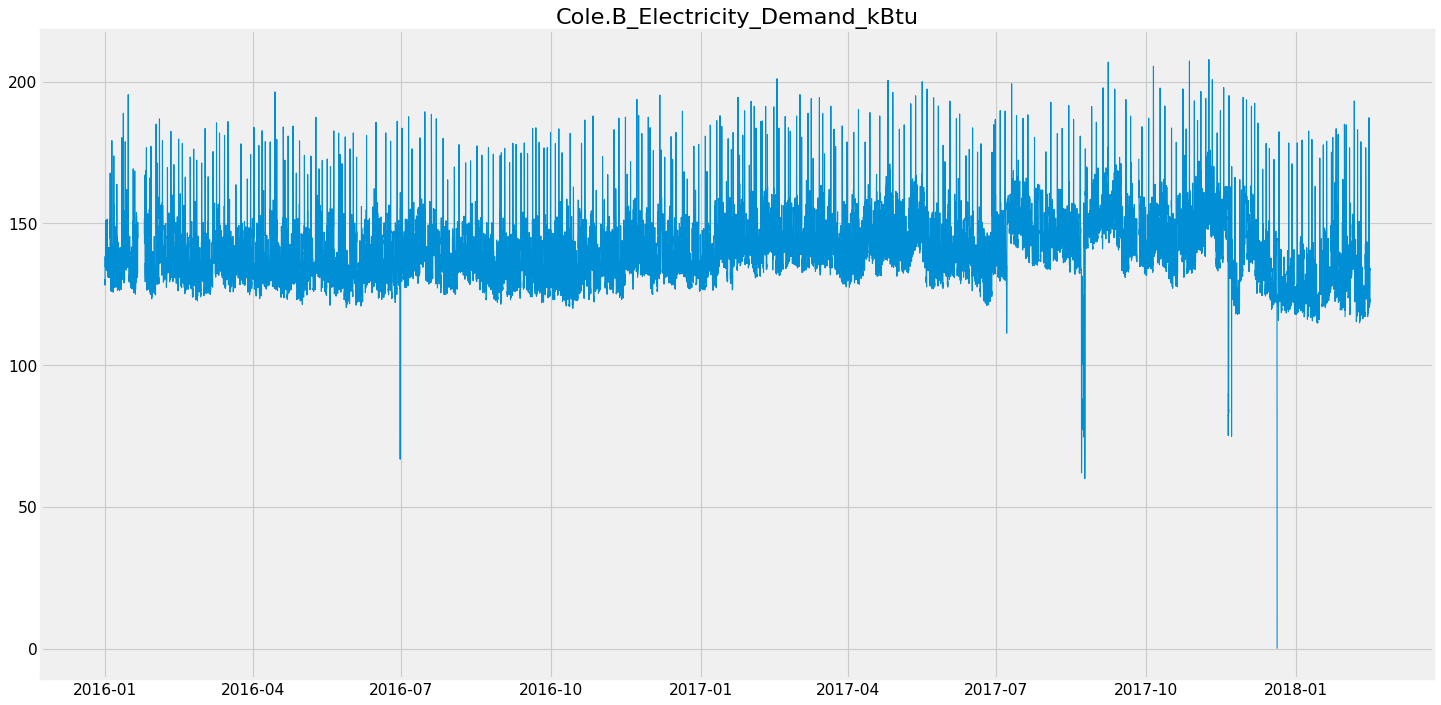

In [4]:
df = pc.get_stream_by_point(point[0], start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

In [5]:
df.tail()

,Cole.B_Electricity_Demand_kBtu
Timestamp,
2019-08-20 04:00:00,NaN
2019-08-20 05:00:00,NaN
2019-08-20 06:00:00,NaN
2019-08-20 07:00:00,NaN
2019-08-20 08:00:00,NaN


## Load arguments to create model and remove anomalies

In [6]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest' or None 
    'model_type': 'LSTM',
    
    'epochs' :'default',
################################### Data Pre-processing ################################ 
    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if user wants the data to be cleaned prior to model generation 
    'clean_data': True,
    
    
    #clean_type can be either 'value' (any points below or above a threshold will be cut out)
    # or 'iqr' (interquantile range)
    'clean_type': 'iqr',

    
    # if clean_type is IQR then determine the IQR to cut at, an int or float value (ie. 1.5 or 2)
    #if clean is 'value' then pass the value  or a list as shown below
    #if values the threshold =  [lower_bound, upper_bound] (ie. [1200, 3500])
    'threshold': 3.5,
    
    #This will determine if the user wants to see the plot in which the cutoff value(s) are shown 
    'show_cutoff_plot': True,
    
    #This will show if the user wants to see the plot with the cleaned training data and test data combined
    'show_cleaned_plot': True,
    
    #determine what method to use when cleaning the data: 'bfill' (back fill) or 'ffill' (foward fill)  
    'method': 'bfill',
    
########################################### Model Specific Parameters ###################    
    
    #determine if model should train on residuals or the normal data, if None
    'train_on_residuals': False,
    
    #For LSTM only,this will generate the plot of the nueral network's validation and mae loss as a function of epochs
    'show_training_plot' : True,
    
    #show the plots of Training (Modeled vs Actual) and Testing (Modeled vs Actual) plots
    'show_results_plots' : True,
    
##################################################### Anomalies #######################
   
    #This will determine if the user wants to see the plot with the anomalies
    'show_anomalies_plot': True,
    
    #This will deteremine if the user wants to see a plot with the removed anomalies
    'show_removed_anomalies_plot': True
    
    

}
check_kwargs(kwargs)

'Good values!'

lower_bound: 81.465962 and upper_bound: 196.587756


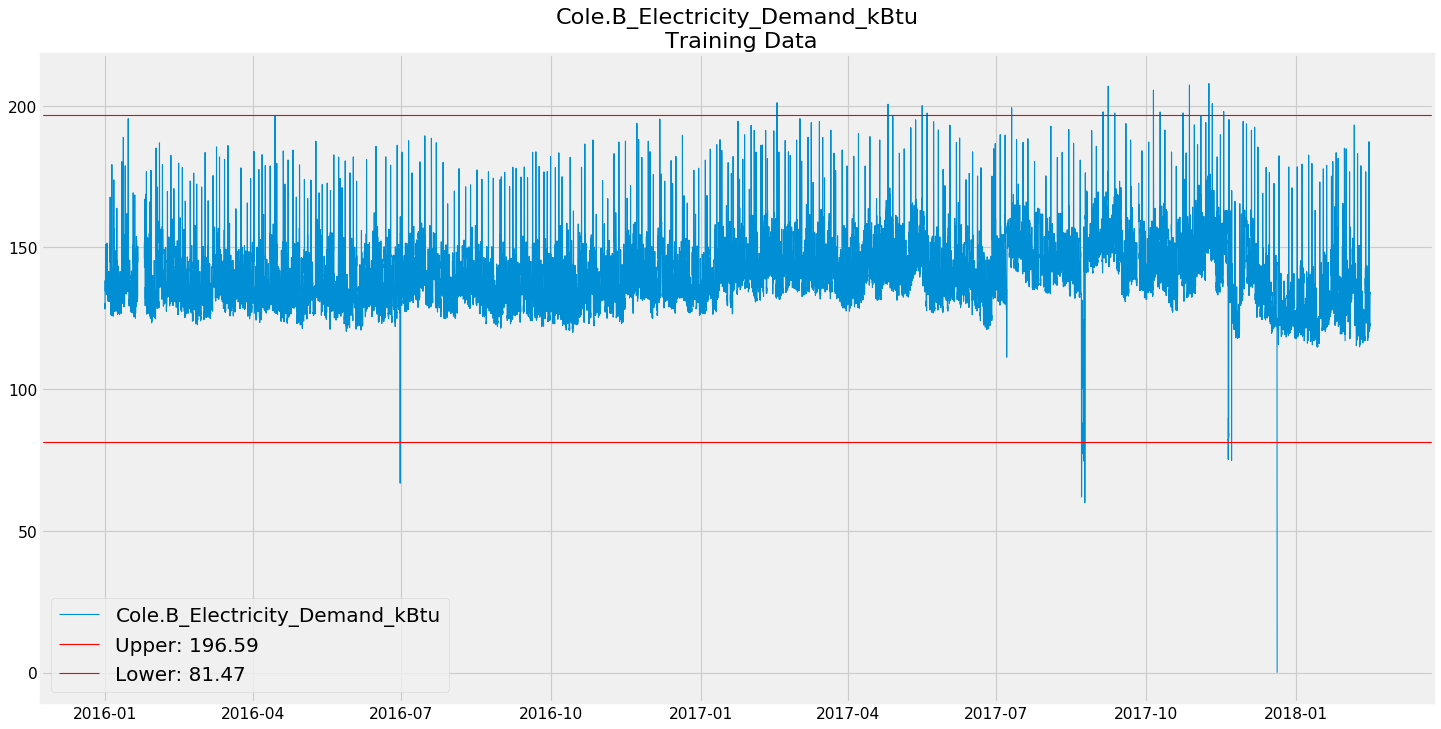

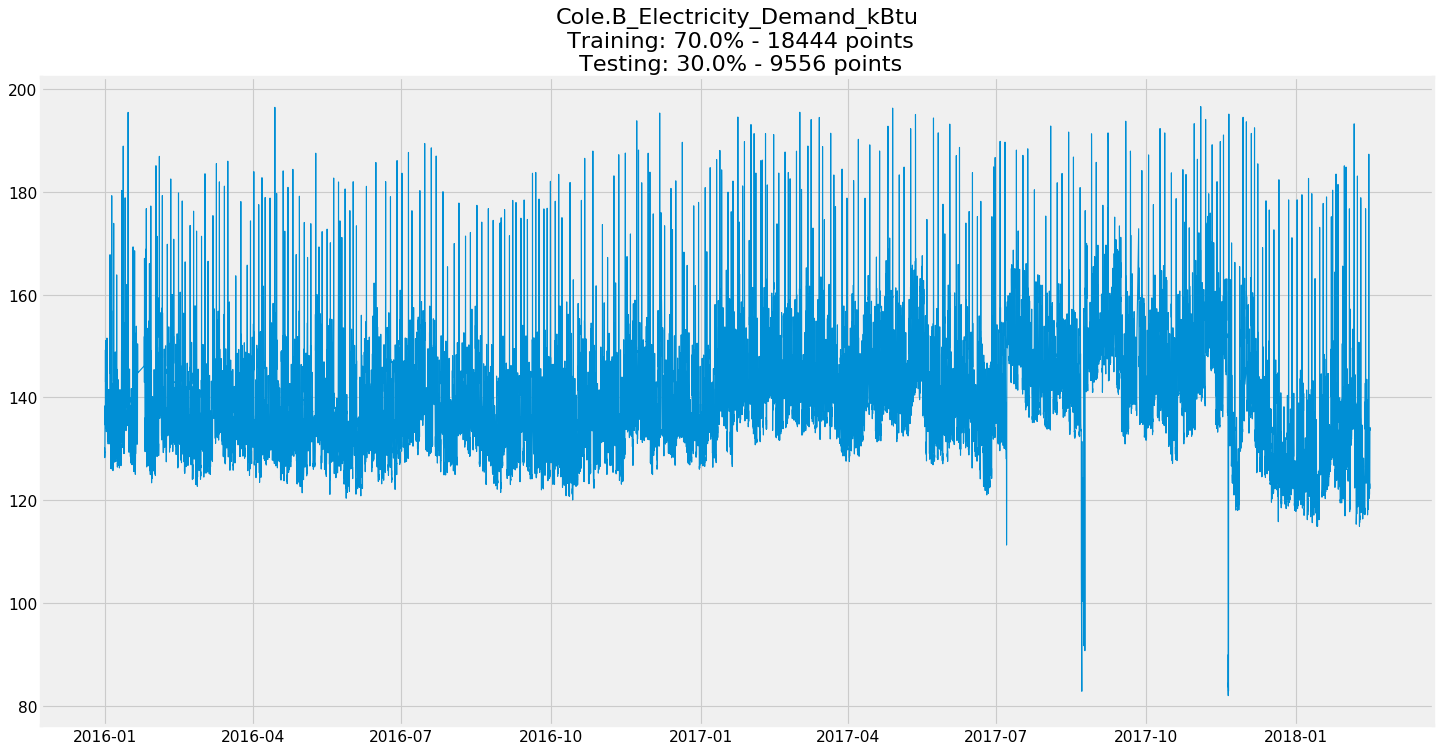

In [7]:
if kwargs['model_type'] is not None:
    df1 = split_and_clean(df, kwargs)

### Showing Decoposed Data (optional)
If user wants to see decomposed data then uncomment following line of code

In [8]:
#plot_decomposed_data(df1[point[0]], kwargs)

## Creating the Model based on arguments passed

The scrip will generate either an `LSTM`, `Random Forest` or `None` based on arguments passed and will generate plots if user determines

Using TensorFlow backend.


Grabbing WebIDs ...
WebID collection complete!
09:50:47: Sending API request... Chunk 1 of 1
09:50:51: Response recieved for 3 tags! (3.61)


W0820 09:50:51.852660 4526327232 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 09:50:51.869254 4526327232 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 09:50:51.872986 4526327232 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Removed: 0 rows


W0820 09:50:52.173799 4526327232 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 09:50:52.344187 4526327232 deprecation.py:323] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 09:50:53.047373 4526327232 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0820 09:50:53.215476 4526327232 deprecation_wrapper.py:119] From /Users/jos

Train on 15607 samples, validate on 6690 samples
Epoch 1/23
15607/15607 [==============================] - 3s 207us/step - loss: 0.0128 - val_loss: 0.0050
Epoch 2/23
15607/15607 [==============================] - 2s 129us/step - loss: 0.0037 - val_loss: 0.0044
Epoch 3/23
15607/15607 [==============================] - 2s 131us/step - loss: 0.0035 - val_loss: 0.0044
Epoch 4/23
15607/15607 [==============================] - 2s 128us/step - loss: 0.0035 - val_loss: 0.0046
Epoch 5/23
15607/15607 [==============================] - 2s 128us/step - loss: 0.0035 - val_loss: 0.0048
Epoch 6/23
15607/15607 [==============================] - 2s 128us/step - loss: 0.0037 - val_loss: 0.0051
Epoch 7/23
15607/15607 [==============================] - 2s 128us/step - loss: 0.0039 - val_loss: 0.0051
Epoch 8/23
15607/15607 [==============================] - 2s 129us/step - loss: 0.0041 - val_loss: 0.0050
Epoch 9/23
15607/15607 [==============================] - 2s 129us/step - loss: 0.0041 - val_loss: 0.00

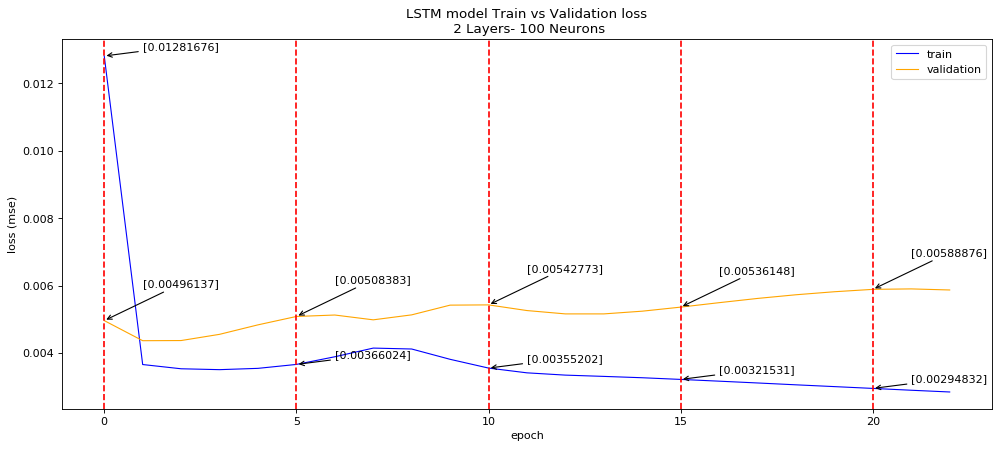

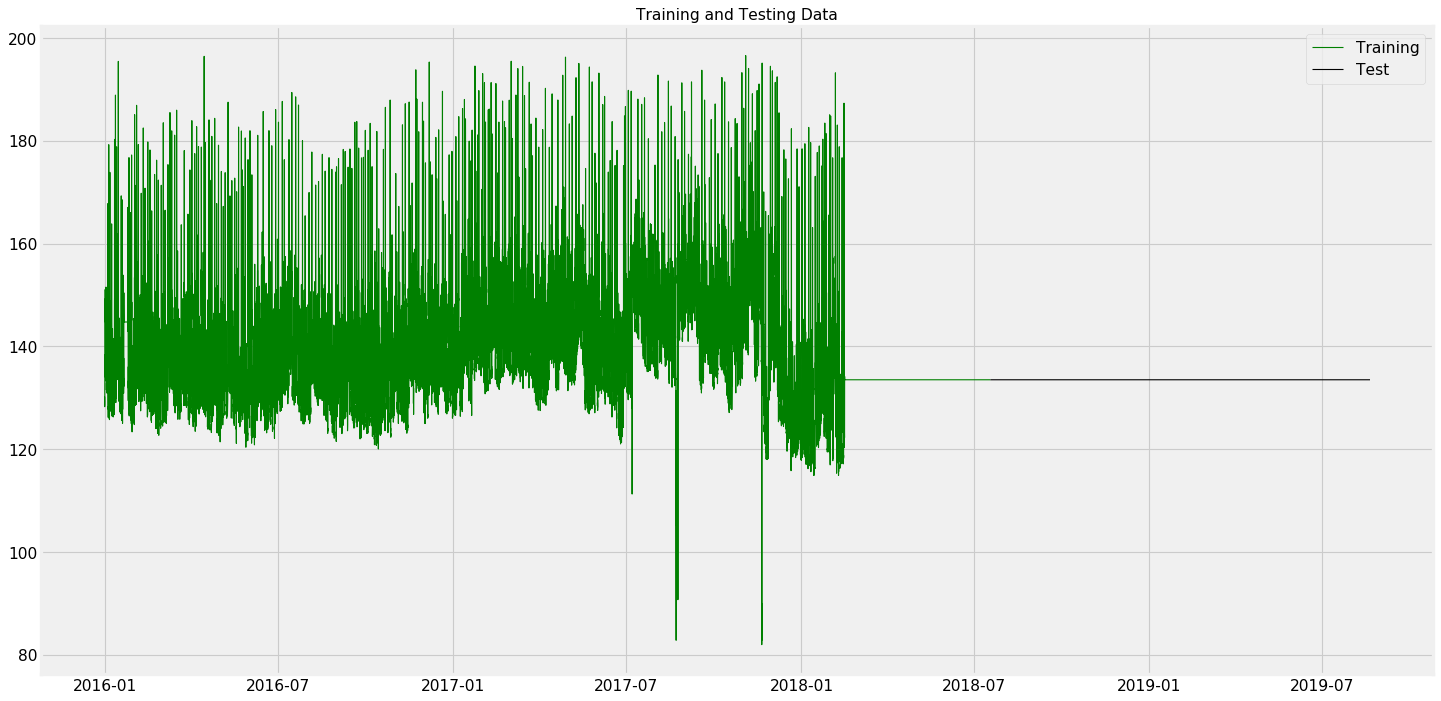

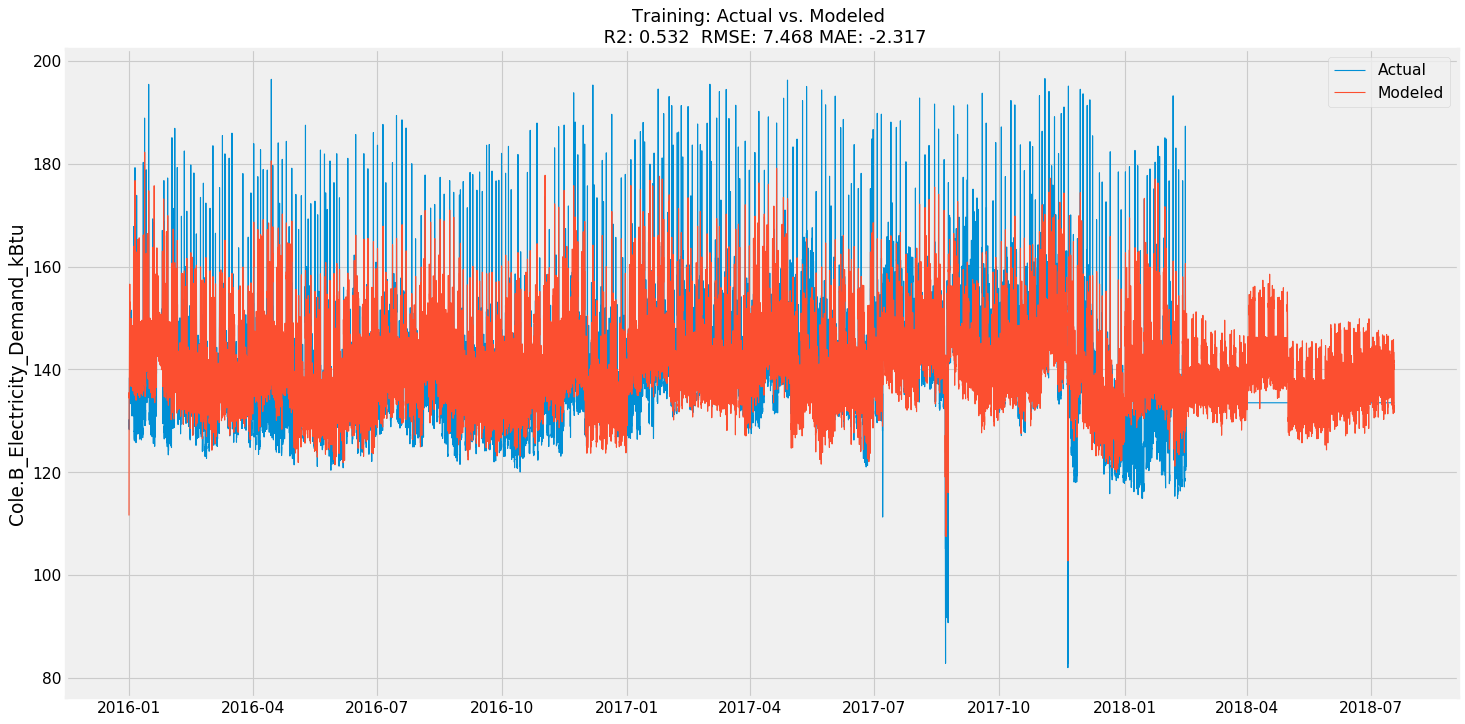

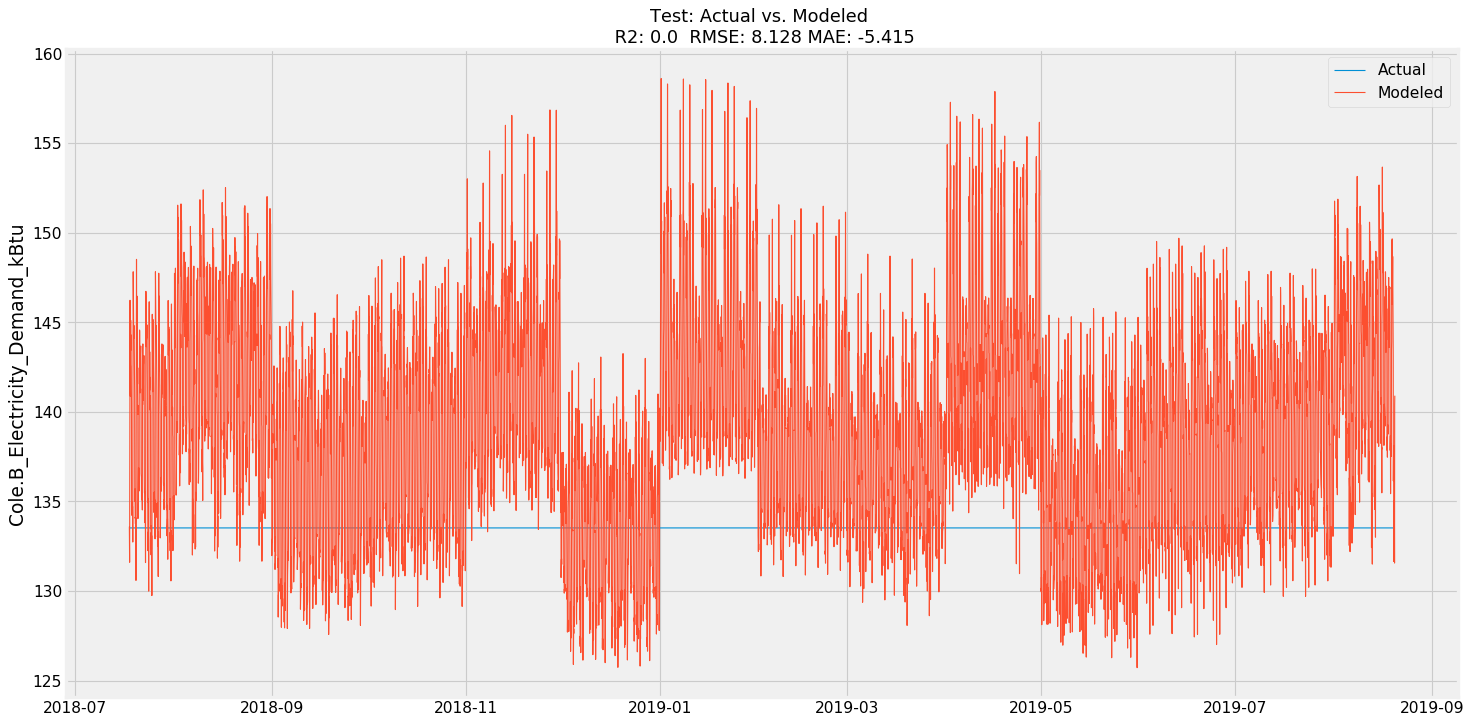

In [9]:
kwargs.update({'epochs':23})
from src.model_generator import *

if kwargs['model_type'] is not None:
    train_df, test_df = create_model(df1, kwargs)
else:
    df3 = create_model(df, kwargs)
    test_df = df3.copy()
    del df3

## Finding Anomalies
This method creates a datframe with Results = Actual - Modeled and uses either *interquantile range* or *standard deviation* to find anomalies.

`args`: Can be either `'iqr'` (inter quantile range)  `'sd'` (standard deviation) with their respective thresholds , or `'percent'` which is the percent error in modeled and actual data. 

**Note** `percent` only to be used with data that has used a model to train on.

**ex1.** `{'anomalies_method': {'iqr': 7.5}  }`

**ex2.** `{'anomalies_method': {'sd': 3}  }`

**ex3.** `{'anomalies_method': {'percent' : 10.0} }`


In [ ]:

args = {'anomalies_method': 
                    {'iqr': 4.0}  }

check_args(args, kwargs['model_type'])

In [ ]:
a_df = find_anomalies(test_df,args = args, kwargs = kwargs)

## Remove anomalies from dataset

**Returns**: a `DataFrame` with anomalies removed from the dataset


In [ ]:
cleaned_df = drop_anomalies(a_df, kwargs)

## Save Data (optional)

The following code cell will save the `DataFrame` that has the anomalies tagged

The columns are: `Actual`, `Modeled`, `Anomalies` and `Result`


In [ ]:

# from datetime import datetime
# date = datetime.today().strftime('%Y%m%d')
# point_name = kwargs['point']
# a_df.to_csv(f"{point_name}_Anomalies_{date}.csv")